#Import Library dan Konfigurasi PySpark

In [2]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# mengatur konfigurasi spark.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark menggunakan pip
!pip install -q findspark

In [3]:
#import library yang akan digunakan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
import findspark
findspark.init()

In [5]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

# Konfigurasi dan inisialisasi sesi Spark
spark = SparkSession.builder.master("local").appName("wind_turbine_project").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local appName=wind_turbine_project>

In [8]:
# Import dataset
spark_df = spark.read.csv('sample_data/wind_turbine.csv', header=True, inferSchema=True)

# Menyimpan (cache) DataFrame Spark di dalam memori
spark_df.cache()

# Mengubah seluruh nama kolom menjadi huruf kecil
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])

# Data Understanding


In [9]:
# Menampilkan 5 record teratas
print('Show the first 5 rows')
print(spark_df.show(5))
print()

# Menampilkan tipe data
print('What are the variable data types?')
print(spark_df.printSchema())
print()

# Menampilkan jumlah baris pada dataset
print('How many observations do we have?')
print(spark_df.count())

Show the first 5 rows
+----------------+-------------------+----------------+-----------------------------+------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|
+----------------+-------------------+----------------+-----------------------------+------------------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|
+----------------+-------------------+----------------+-----------------------------+------------------+
only showing top 5 rows

None

Wh

In [10]:
# Ekstrak substrings dari kolom "date/time" dan membuat dua kolom baru, yaitu "month" dan "hour"

from pyspark.sql.functions import substring
spark_df = spark_df.withColumn("month", substring("date/time", 4,2))
spark_df = spark_df.withColumn("hour", substring("date/time", 12,2))

# Konversi string month dan hour variables menjadi integer
from pyspark.sql.types import IntegerType
spark_df = spark_df.withColumn('month', spark_df.month.cast(IntegerType()))
spark_df = spark_df.withColumn('hour', spark_df.hour.cast(IntegerType()))

print(spark_df.show(5))

+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|hour|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|   0|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|   0|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|   0|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|   0|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1|   0|
+----------------+-------------------+----------------+-----------------

# Exploratory Data Analysis

In [11]:
# Mengatur format tampilan angka pecahan 2 belakang koma pada Pandas DataFrame
pd.options.display.float_format = '{:.2f}'.format
spark_df.select('wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)').toPandas().describe()

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
count,40058.00,40058.00,40058.00
mean,7.43,1454.38,1270.17
std,4.21,1368.97,1305.08
min,0.00,0.00,-2.47
25%,4.04,129.95,38.76
50%,6.96,996.88,761.01
75%,10.20,2912.31,2419.16
max,25.21,3600.00,3618.73


## 1. Distribusi Variabel

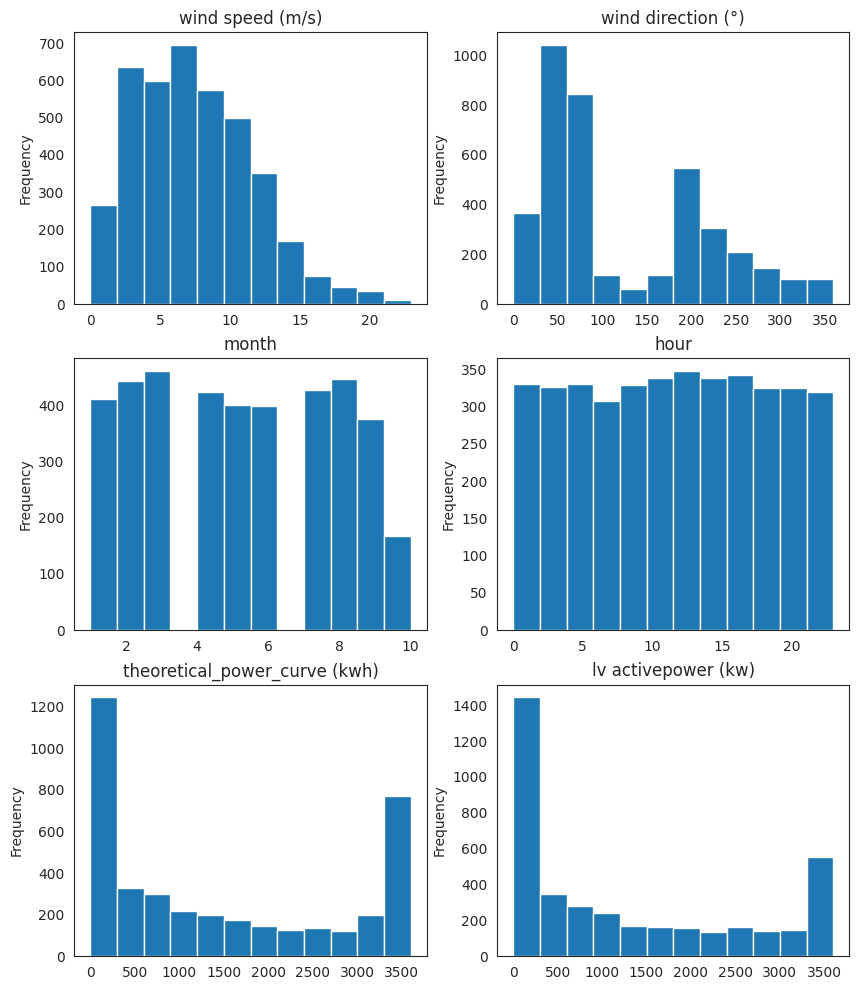

In [12]:
# Mengambil sample dari dataset wind_turbine.csv
sample_df = spark_df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

# Membuat visualisasi histogram
columns = ['wind speed (m/s)', 'wind direction (°)', 'month', 'hour', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(10,12))
for each in columns:
    plt.subplot(3,2,i)
    sample_df[each].plot.hist(bins=12)
    plt.title(each)
    i += 1

## 2. Rata-rata produksi daya per bulan

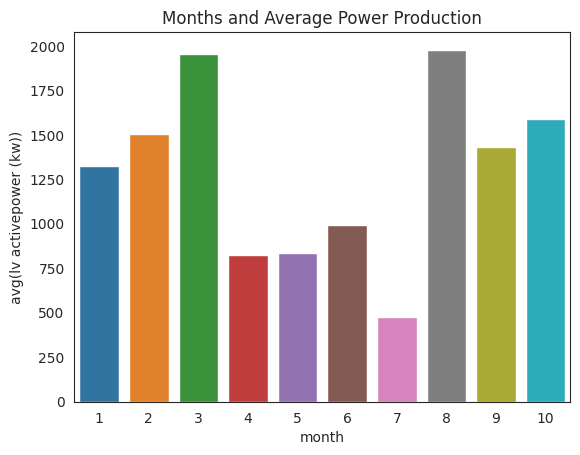

In [13]:
# Menghitung rata-rata produksi daya berdasarkan bulan
monthly = spark_df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly)
plt.title('Months and Average Power Production');

## 3. Rata-rata Produksi Daya per Jam

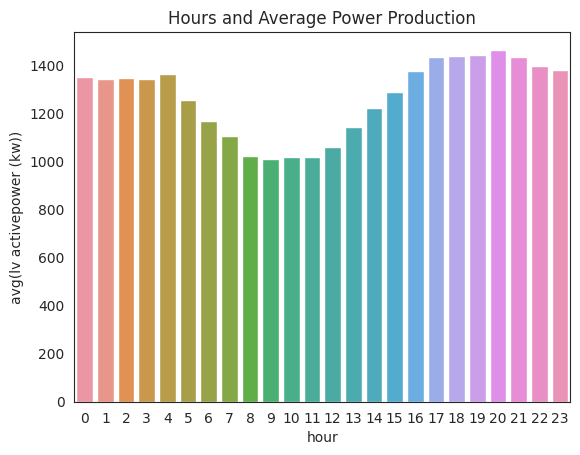

In [14]:
# Menghitung rata-rata produksi daya berdasarkan jam
hourly = spark_df.groupby('hour').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='hour', y='avg(lv activepower (kw))', data=hourly)
plt.title('Hours and Average Power Production');

## 4. Hubungan antara wind speed, wind direction and power production

,wind speed (m/s),wind direction (°),month,hour,theoretical_power_curve (kwh),lv activepower (kw)
wind speed (m/s),1.00,-0.11,-0.08,0.04,0.95,0.91
wind direction (°),-0.11,1.00,-0.30,-0.01,-0.13,-0.10
month,-0.08,-0.30,1.00,-0.01,-0.04,0.01
hour,0.04,-0.01,-0.01,1.00,0.04,0.04
theoretical_power_curve (kwh),0.95,-0.13,-0.04,0.04,1.00,0.94
lv activepower (kw),0.91,-0.10,0.01,0.04,0.94,1.00


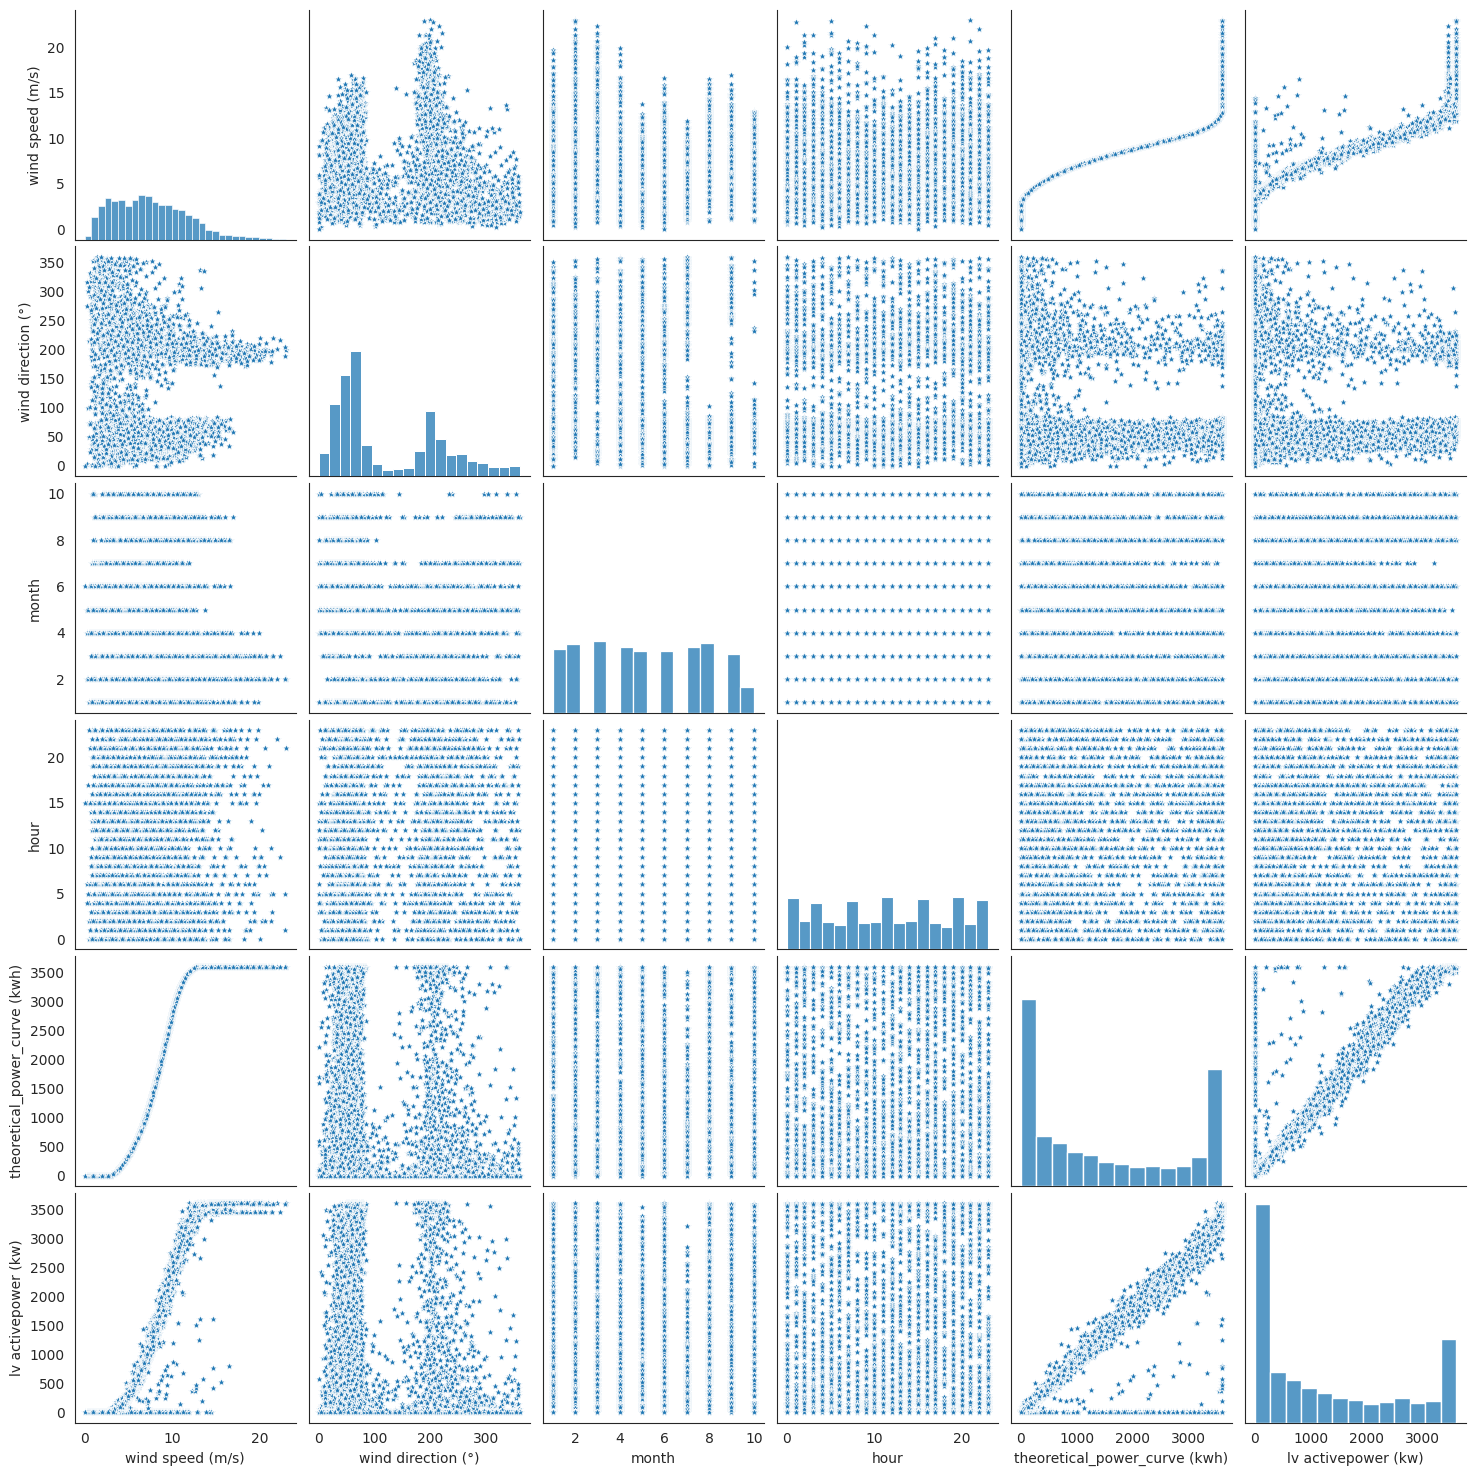

In [15]:
display(sample_df[columns].corr())
sns.pairplot(sample_df[columns], markers='*');

## 5. Rata-rata daya yang dihasilkan tiap kecepatan angin yang naik 5 m/s

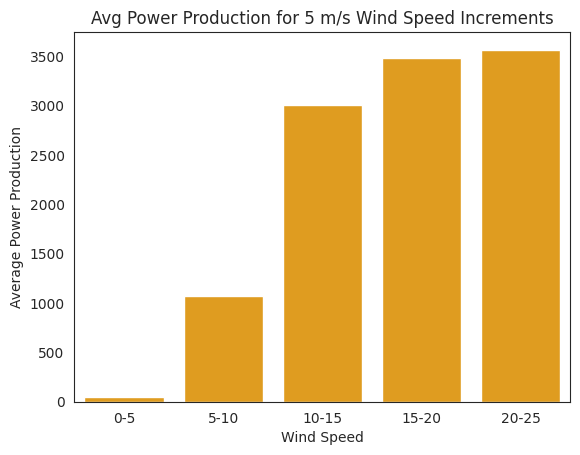

In [16]:
# Menghitung rata-rata produksi daya berdasarkan kelompok kecepatan angin dengan interval 5 m/s,
wind_speed = []
avg_power = []
for i in [0,5,10,15,20]:
    avg_value = spark_df.filter((spark_df['wind speed (m/s)'] > i)
                                & (spark_df['wind speed (m/s)'] <= i+5))\
                                .agg({'lv activepower (kw)':'mean'}).collect()[0][0]
    avg_power.append(avg_value)
    wind_speed.append(str(i) + '-' + str(i+5))

sns.barplot(x=wind_speed, y=avg_power, color='orange')
plt.title('Avg Power Production for 5 m/s Wind Speed Increments')
plt.xlabel('Wind Speed')
plt.ylabel('Average Power Production');

## 6. Daya yang dihasilkan menurut pabrikan vs keadaan aslinya

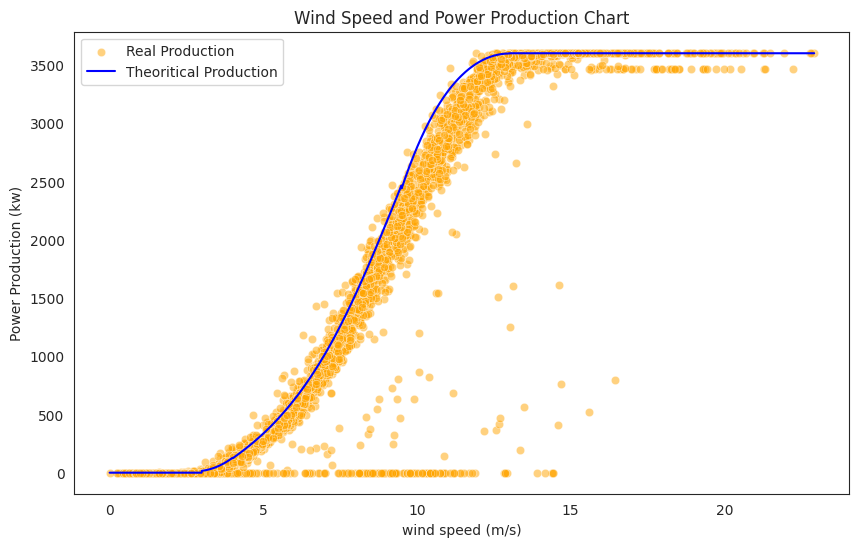

In [17]:
# Membuat visualisasi scatter plot dengan Seaborn
plt.figure(figsize=(10,6))
sns.scatterplot(x='wind speed (m/s)', y='lv activepower (kw)', color='orange', label='Real Production', alpha=0.5, data=sample_df)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', color='blue', label='Theoritical Production', data=sample_df)
plt.title('Wind Speed and Power Production Chart')
plt.ylabel('Power Production (kw)');

## 7. Ambang batas kecepatan angin ketika daya pabrikan nol

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
50,1.67,0.00,0.00
3606,1.96,0.00,0.00
2014,2.22,0.00,0.00
204,1.98,0.00,0.00
1104,2.81,0.00,0.00


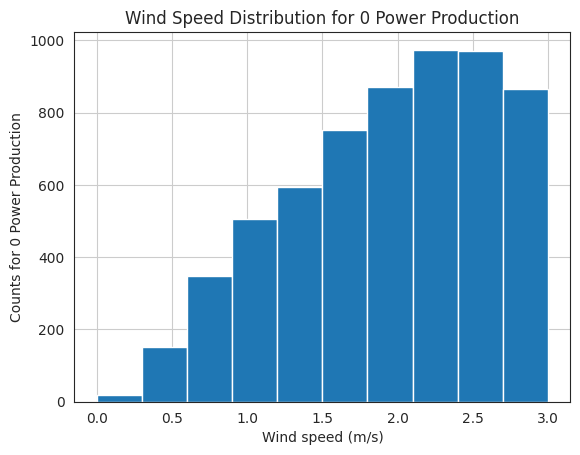

In [18]:
# Memfilter data dimana real dan theoritical power productions = 0
zero_theo_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                                  & (spark_df['theoretical_power_curve (kwh)'] == 0)).toPandas()

display(zero_theo_power[['wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']].sample(5))

# Menampilkan grafik histogram dari kecepatan angin untuk data dengan power production = 0
zero_theo_power['wind speed (m/s)'].hist()
plt.title('Wind Speed Distribution for 0 Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Power Production');

## 8. Alasan produksi daya tetap 0 padahal kecepatan anginnya lebih dari 3 m/s

In [19]:
# Melakukan pengecekan untuk wind speed > 3m/s dan power production = 0,
zero_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)).toPandas()
display(zero_power.head())
print('Data dengan wind speed > 3m/s dan power production = 0 sebanyak ) ', len(zero_power))

,date/time,lv activepower (kw),wind speed (m/s),theoretical_power_curve (kwh),wind direction (°),month,hour
0,03 01 2018 15:40,0.00,3.74,83.99,245.07,1,15
1,03 01 2018 16:40,0.00,3.03,17.18,221.09,1,16
2,03 01 2018 16:50,0.00,3.20,25.43,232.68,1,16
3,03 01 2018 17:00,0.00,3.91,110.98,241.97,1,17
4,04 01 2018 13:50,0.00,3.44,45.74,79.09,1,13


Data dengan wind speed > 3m/s dan power production = 0 sebanyak )  2620


## 9. Kecepatan angin untuk produksi daya 0

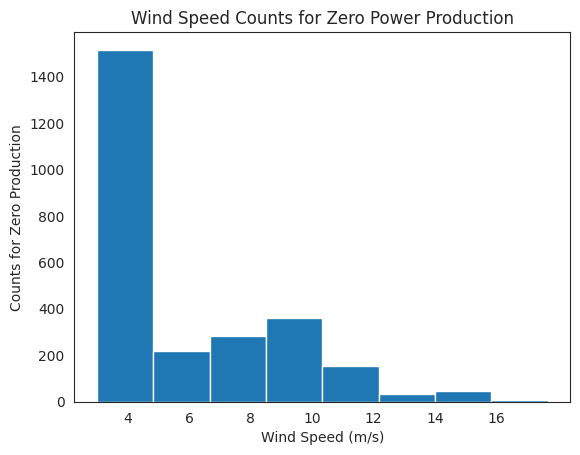

In [20]:
zero_power['wind speed (m/s)'].plot.hist(bins=8)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Counts for Zero Production')
plt.title('Wind Speed Counts for Zero Power Production')
plt.xticks(ticks=np.arange(4,18,2));

In [21]:
# menghilangkan dataset yang tidak sesuai dengan kondisi atau kriteria tertentu
spark_df = spark_df.filter(~((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)))

## 10. Mengecek adanya outlier

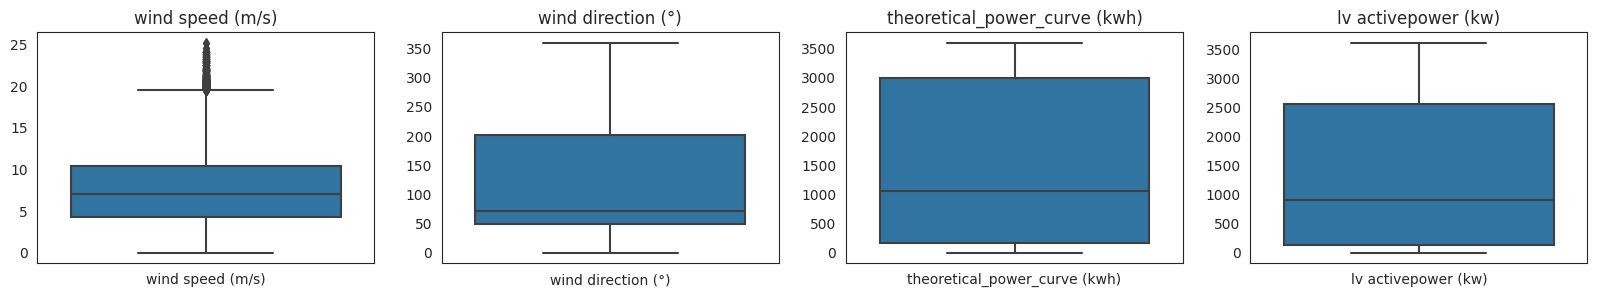

In [22]:
columns = ['wind speed (m/s)', 'wind direction (°)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(20,3))
for each in columns:
    df = spark_df.select(each).toPandas()
    plt.subplot(1,4,i)
    sns.boxplot(df)
    plt.title(each)
    i += 1

In [23]:
# Membuat Pandas Dataset
wind_speed = spark_df.select('wind speed (m/s)').toPandas()

# Menghitung kuantil dan rentang antarkuantil
Q1 = wind_speed['wind speed (m/s)'].quantile(0.25)
Q3 = wind_speed['wind speed (m/s)'].quantile(0.75)
IQR = Q3-Q1

# Mendefinisikan nilai ambang batas dataset
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

print('Quantile (0.25): ', Q1, '  Quantile (0.75): ', Q3)
print('Lower threshold: ', lower, ' Upper threshold: ', upper)

Quantile (0.25):  4.256504058837888   Quantile (0.75):  10.368369817733674
Lower threshold:  -4.911294579505792  Upper threshold:  19.536168456077355


In [24]:
# Mencari nilai outlier dari upper treshold
outlier_tf = (wind_speed['wind speed (m/s)'] < lower) | (wind_speed['wind speed (m/s)'] > upper)

print('Total Number of Outliers: ', len(wind_speed['wind speed (m/s)'][outlier_tf]))
print('--'*15)
print('Some Examples of Outliers:')
print(wind_speed['wind speed (m/s)'][outlier_tf].sample(10))

Total Number of Outliers:  338
------------------------------
Some Examples of Outliers:
3247   21.25
2532   22.00
2418   20.00
3532   23.22
3257   19.99
3224   19.76
7506   19.95
3485   19.77
8906   20.79
3239   19.55
Name: wind speed (m/s), dtype: float64


In [25]:
# Menampilkan nilai rata-rata 'lv activepower (kw)'
spark_df.select('wind speed (m/s)', 'lv activepower (kw)')\
.filter(spark_df['wind speed (m/s)'] >= 19)\
.agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      3561.3272022843616|
+------------------------+



In [26]:
# Mengatur nilai maksimum 19, untuk semua nilai 'wind speed (m/s)'
from pyspark.sql import functions as F
spark_df = spark_df.withColumn('wind speed (m/s)',
                               F.when(F.col('wind speed (m/s)') > 19.447, 19)
                               .otherwise(F.col('wind speed (m/s)')))
spark_df.count()

37438

## 11. Kriteria umum untuk memproduksi daya

In [27]:
# Rata-rata produksi daya sesuai dengan kriteria produksi daya
spark_df.filter(((spark_df['month'] == 3) | (spark_df['month'] == 8) | (spark_df['month'] == 11))
                & ((spark_df['hour'] >= 16) | (spark_df['hour'] <= 24))
                & ((spark_df['wind direction (°)'] > 0) | (spark_df['wind direction (°)'] < 90))
                & ((spark_df['wind direction (°)'] > 180) | (spark_df['wind direction (°)'] < 225))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      2057.6124812723624|
+------------------------+



In [28]:
# Rata-rata produksi daya tidak sesuai dengan kriteria produksi daya
spark_df.filter((spark_df['month'] == 7)
                & ((spark_df['hour'] >= 9) | (spark_df['hour'] <= 11))
                & ((spark_df['wind direction (°)'] > 90) | (spark_df['wind direction (°)'] < 160))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|       503.1644205414878|
+------------------------+



# Data Preparation

In [29]:
# Mempersiapkan variabel independen (features)
from pyspark.ml.feature import VectorAssembler

# Membuat kolom baru 'label' dalam DataFrame spark_df dengan mengambil nilai dari kolom 'lv activepower (kw)'.
spark_df = spark_df.withColumn('label', spark_df['lv activepower (kw)'])

# List yang berisi nama variabel yang akan digunakan sebagai fitur
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(spark_df)

# Memilih kolom 'features' dan 'label'
final_df = va_df.select('features', 'label')
final_df.show(10)

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,0.0,5.311336...|380.047790527343|
|[1.0,0.0,5.672166...| 453.76919555664|
|[1.0,0.0,5.216036...|306.376586914062|
|[1.0,0.0,5.659674...|419.645904541015|
|[1.0,0.0,5.577940...|380.650695800781|
|[1.0,0.0,5.604052...|402.391998291015|
|[1.0,1.0,5.793007...|447.605712890625|
|[1.0,1.0,5.306049...|     387.2421875|
|[1.0,1.0,5.584629...|463.651214599609|
|[1.0,1.0,5.523228...|439.725708007812|
+--------------------+----------------+
only showing top 10 rows



## Train Test Split

In [30]:
# Split dataset menjadi 20% testing dan 80% training
splits = final_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())


Train dataset:  29994
Test dataset :  7444


## Modelling

In [31]:
# Import  algoritma Gradient Boosted Tree (GBT)
from pyspark.ml.regression import GBTRegressor

# Membuat objek regresor GBT
gbm = GBTRegressor(featuresCol='features', labelCol='label')

# Melatih model dengan data training
gbm_model = gbm.fit(train_df)

# Membuat prediksi menggunakan data training
y_pred = gbm_model.transform(test_df)

#  Menampilkan 20 baris pertama dari Dataset
y_pred.select('label', 'prediction').show(20)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|             0.0| 29.08547588602194|
|574.656921386718| 530.2798990168208|
|419.645904541015|488.94462145455924|
| 453.76919555664|488.94462145455924|
|685.547424316406| 633.2516203210259|
|932.308410644531| 822.8724282650783|
|933.123291015625| 971.3123820479116|
|1182.03503417968|1106.7715020301387|
|1202.81103515625|1106.7715020301387|
|1340.30395507812|1300.4400694185658|
|1999.54602050781| 1669.731662311196|
|1724.67199707031|1678.6411997529071|
|  2169.958984375|1695.1993828838297|
|2331.07495117187|2116.7731043296835|
|884.019226074218|1192.0666742962424|
|1141.15905761718|1638.1960541178876|
|  2796.876953125| 2720.785791162569|
|3603.46899414062|3315.1102937315286|
|331.209503173828| 774.3499561096478|
|3593.00708007812|3492.4995506098817|
+----------------+------------------+
only showing top 20 rows



# Model Evaluation

In [32]:
# Mengevaluasi kinerja model regresi Gradient Boosted Tree
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.983944280948254
MAE      :  73.99104476788749
RMSE     :  165.07927523800177


## Membandingkan model dengan real power dan theoretical power

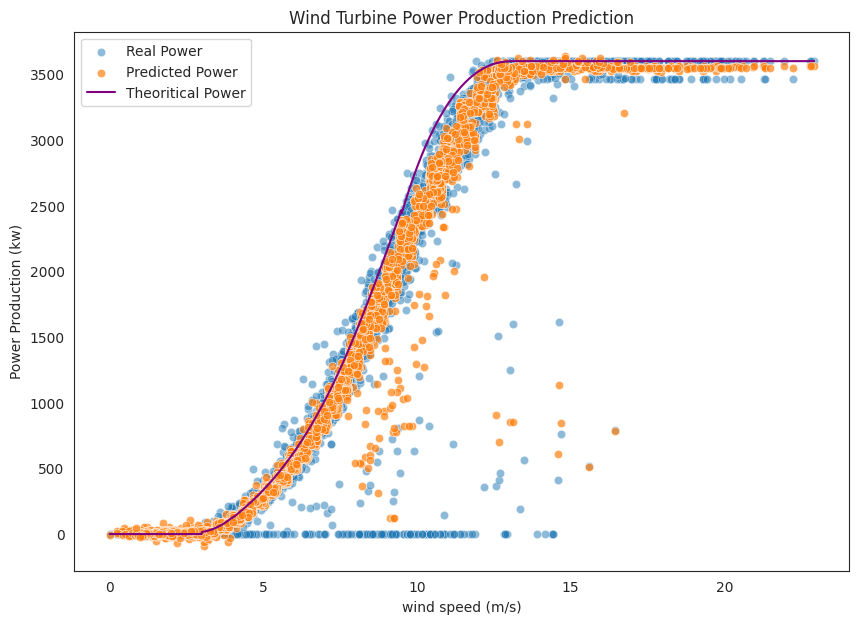

In [33]:
# Konversi DataFrame Pandas ke Spark DataFrame:
eva_df = spark.createDataFrame(sample_df)

# Menambahkan Kolom Label lv activepower (kw)
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

# Mendefinisikan Variabel dan Membuat Vektor Fitur
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Memilih Kolom Features dan Label
vec_df = vec_df.select('features', 'label')

# Memprediksi Menggunakan Model Gradient Boosted Tree:
preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Menggabungkan DataFrame untuk Perbandingan:
frames = [sample_df[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

# Memvisualisasikan prediksi dengan power sebenarnya
plt.figure(figsize=(10,7))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();